# Project 3.2
#### Derek Caramella
#### DSCC 275: Times Series Analysis & Forecasting
#### Due: 12 December 2021

## Overview
In this project, you will work with LSTM-based autoencoders to classify human heart beats for heart disease diagnosis. The dataset contains 5,000 Time Series examples with 140 timesteps. Each time-series is an ECG or EKG signal that corresponds to a single heartbeat from a single patient with congestive heart failure. An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. There are 5 types of hearbeats (classes) that can be classified: i) Normal (N); ii) R-on-T Premature Ventricular Contraction (R on-T PVC); iii) Premature Ventricular Contraction (PVC); iv) Supra-ventricular Premature or Ectopic Beat (SP or EB); v) Unclassified Beat (UB). The shape of the time-series and the position of the impulses allows doctors to diagnose these different conditions. For the purposes of this project, we are interested in 2 classes: <i>Normal</i> and <i>Abnormal</i> (which includes class 2-5 above merged).  

This is an example of an anomaly detection problem where class imbalance exists, i.e. number of each of the individual positive (abnormal) instances are smaller than the normal case. The autoencoder approach is suited well for such <b>applications of anomaly detection</b>. In anomaly detection, we learn the pattern of a normal process. Anything that does not follow this pattern is classified as an anomaly. For a binary classification of rare events, we can use a similar approach using autoencoders. 

A sample code example (in Python) implementation of auto-encoder “AutoEncoders_anomaly_detection_ecg_SAMPLE.py” is provided. Review and run the code and answer the following questions:

In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from arff2pandas import a2p
import warnings


warnings.filterwarnings('ignore')  # Surpress warnings
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2, font='Times New Roman')
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
#Load the arff files into Pandas data frames / Change Path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(r'ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open(r'ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [4]:
# We'll combine the training and test data into a single data frame. 
# This will give us more data to train our Autoencoder. We'll also shuffle it

df = train.append(test)
df = df.sample(frac=1.0)
df.shape

df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [5]:
# We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [6]:
# Next, we'll rename the last column to `target`, so its easier to reference it

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## Exploratory Data Analysis

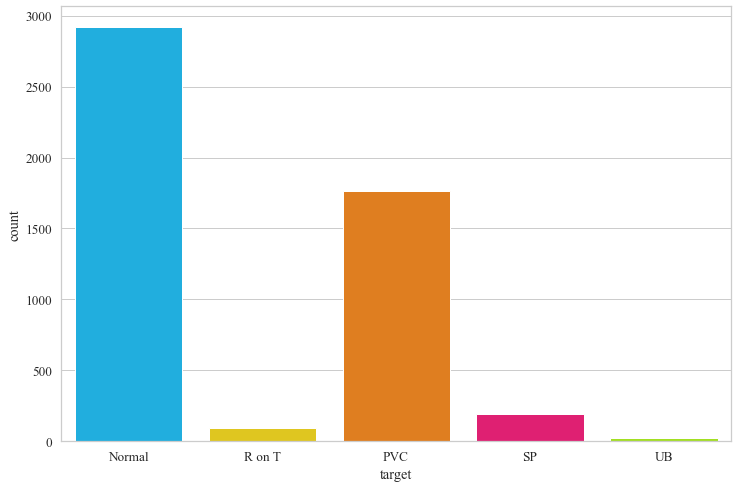

In [7]:
# Check how many examples for each heartbeat class do we have:
df.target.value_counts()

# plot the results
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names)
plt.show()

The normal class, has by far, the most examples. 

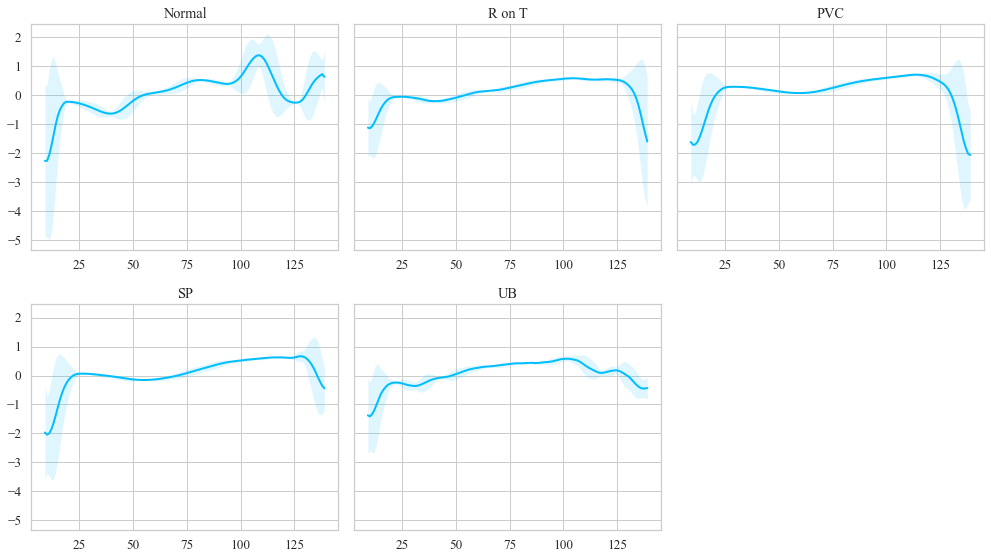

In [8]:
# Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it)
# Time Series for each class:

def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)
    
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125)
    ax.set_title(class_name)


classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8))

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()

## Data Preprocessing

In [9]:
# Let's get all normal heartbeats and drop the target (class) column:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [10]:
# Merge all other classes and mark them as anomalies
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [11]:
# Split the normal examples into train, validation and test sets
train_df, val_df = train_test_split(
    normal_df,
    test_size=0.15,
    random_state=RANDOM_SEED)

val_df, test_df = train_test_split(
    val_df,
    test_size=0.33, 
    random_state=RANDOM_SEED)

In [12]:
def create_dataset(df):
    """Convert our examples into tensors, so we can use them to train our Autoencoder."""
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [13]:
# Each Time Series converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case)

# Create Train, Val and Test datasets:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## LSTM Autoencoder

In [14]:
class Encoder(nn.Module):
    """The general Autoencoder architecture consists of two components. 
    An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.
    The *Encoder* uses LSTM layers to compress the Time Series data input."""
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        
        self.seq_len, self.n_features = seq_len, n_features
        # self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim
        
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True)
        
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        
#         x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn1(x)
#         x, (hidden_n, _) = self.rnn2(x)
        
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [15]:
class Decoder(nn.Module):
    """Decode the compressed representation using a *Decoder*.
    Our Decoder contains LSTM layer and an output layer that gives the final reconstruction."""
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        
        self.seq_len, self.input_dim = seq_len, input_dim
#         self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.hidden_dim, self.n_features = input_dim, n_features
        
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim, 
            num_layers=1, 
            batch_first=True)
        
#         self.rnn2 = nn.LSTM(
#             input_size=input_dim,
#             hidden_size=self.hidden_dim,
#             num_layers=1,
#             batch_first=True)
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        
        x, (hidden_n, cell_n) = self.rnn1(x)
#         x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
    
        return self.output_layer(x)

In [16]:
class RecurrentAutoencoder(nn.Module):
    """Wrap everything into an easy to use module"""
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

<span style="color:red">
    <h1>Question 1</h1>
    <p>
    A critical hyper-parameter when using auto-encoders is the threshold applied to the reconstructed time-series to classify between normal and abnormal. The default threshold in the code is set to 45. Run the code for 50 epochs.
    </p>
</span>

In [17]:
# Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it

# model = RecurrentAutoencoder(seq_len, n_features, 128)
# model = RecurrentAutoencoder(seq_len, n_features, 8)
model = RecurrentAutoencoder(seq_len, n_features, 8)
model = model.to(device)

## Training

In [18]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        
        train_losses = []
        
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
                
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    model.load_state_dict(best_model_wts)
    return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [19]:
model, history = train_model(
    model, 
    train_dataset, 
    val_dataset,
#     n_epochs=25
    n_epochs=50)

Epoch 1: train loss 76.70508575593209 val loss 69.98680924555548
Epoch 2: train loss 69.37738422730526 val loss 69.56770176285363
Epoch 3: train loss 67.44612288715281 val loss 64.7853894412721
Epoch 4: train loss 62.38615131954761 val loss 58.611722041315595
Epoch 5: train loss 54.90959359676018 val loss 52.04429698071789
Epoch 6: train loss 46.20141355552197 val loss 38.887999095200676
Epoch 7: train loss 39.05034845022365 val loss 43.153641547766156
Epoch 8: train loss 36.63970820262806 val loss 37.511513270615715
Epoch 9: train loss 35.00868072186877 val loss 36.74276484727046
Epoch 10: train loss 33.79346684629232 val loss 36.50697399569046
Epoch 11: train loss 32.85211609237283 val loss 34.74379943418015
Epoch 12: train loss 32.121964512309546 val loss 32.41228514726658
Epoch 13: train loss 31.609675195610173 val loss 32.99991804585115
Epoch 14: train loss 31.296374652329014 val loss 31.342035495380493
Epoch 15: train loss 30.769576399425304 val loss 31.24071279727558
Epoch 16: t

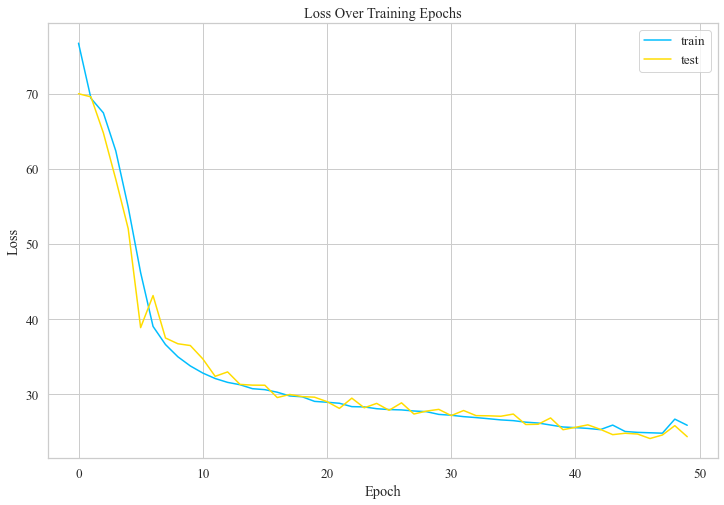

In [20]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss Over Training Epochs')

plt.show()

## Save the Model

In [21]:
MODEL_PATH = 'model50.pth'
torch.save(model, MODEL_PATH)

## Load the Model

In [22]:
MODEL_PATH = 'model50.pth'
model = torch.load(MODEL_PATH)

## Choosing a Threshold

In [23]:
def predict(model, dataset):
    """The reconstruction error on the training set. Let's start by writing a helper function to get 
    predictions from our model"""
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

## Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:
- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

Correct normal predictions: 140/145 (96.55%)
Correct anomaly predictions: 143/145 (98.62%)


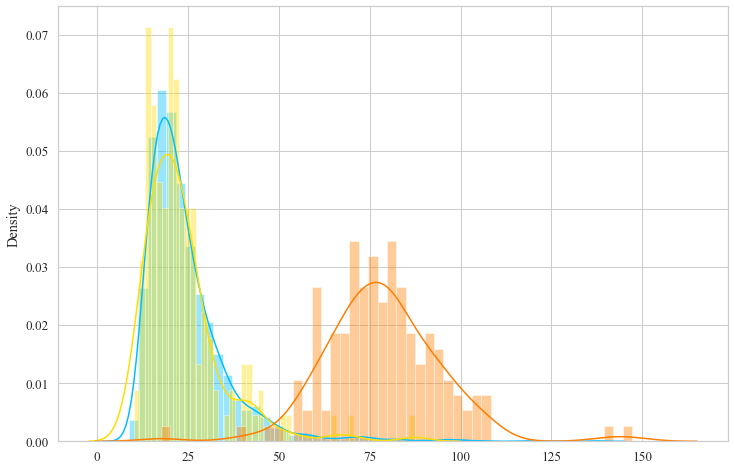

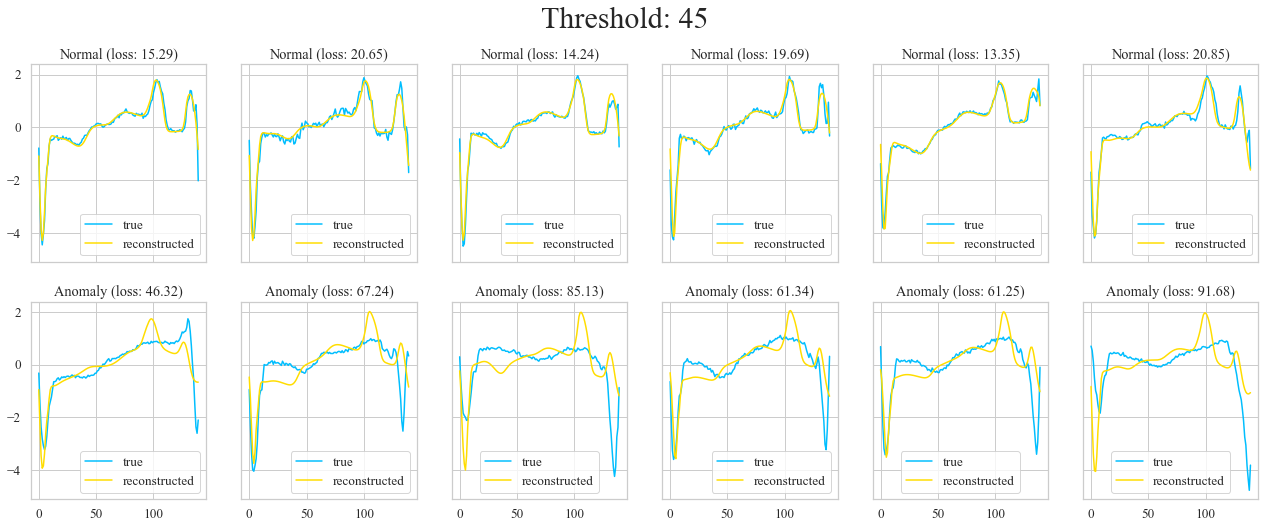

In [24]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 45


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

<span style="color:red">
    <p>
    a) For the normal and abnormal test set defined in the code as “test_normal_dataset” and “anomaly_dataset”, vary the <i>threshold</i> value from 15 to 75 (both included) in increments of 10 and report (as a graph or a table) the proportion of normal and abnormal time-series that were correctly classified, i.e. <i>recall</i>.
    </p>
</span>

### Threshold: 15

Correct normal predictions: 27/145 (18.62%)
Correct anomaly predictions: 145/145 (100.0%)


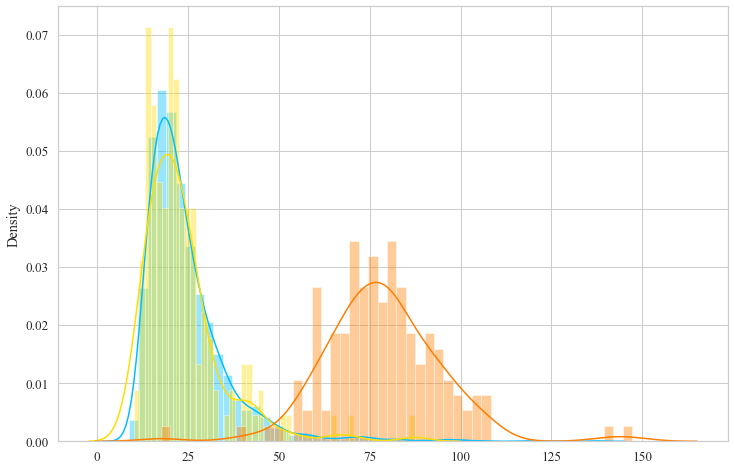

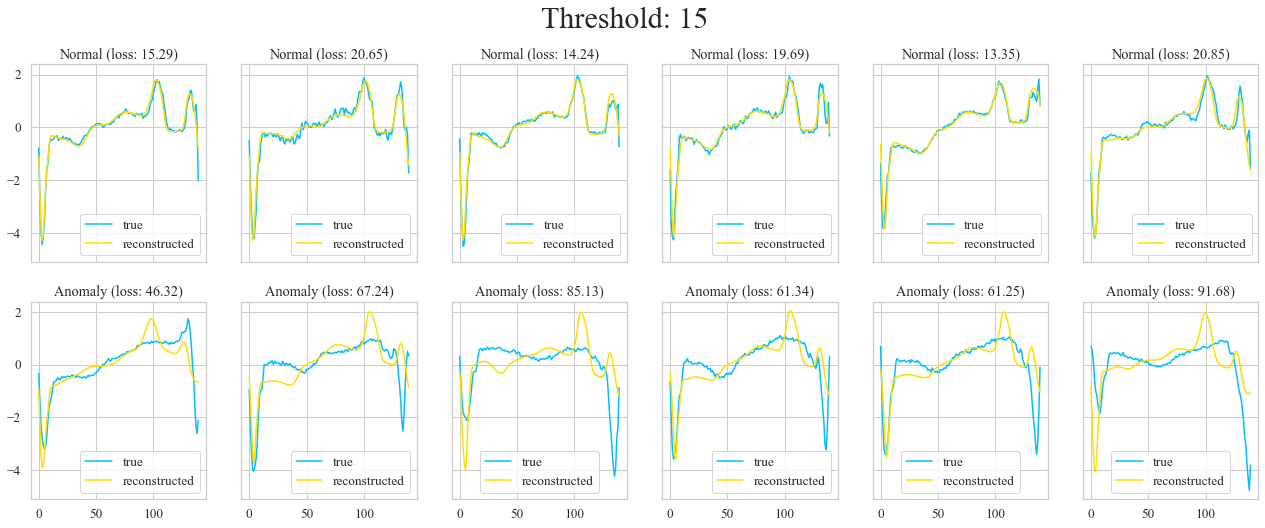

In [25]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 15


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold: 25

Correct normal predictions: 101/145 (69.66%)
Correct anomaly predictions: 144/145 (99.31%)


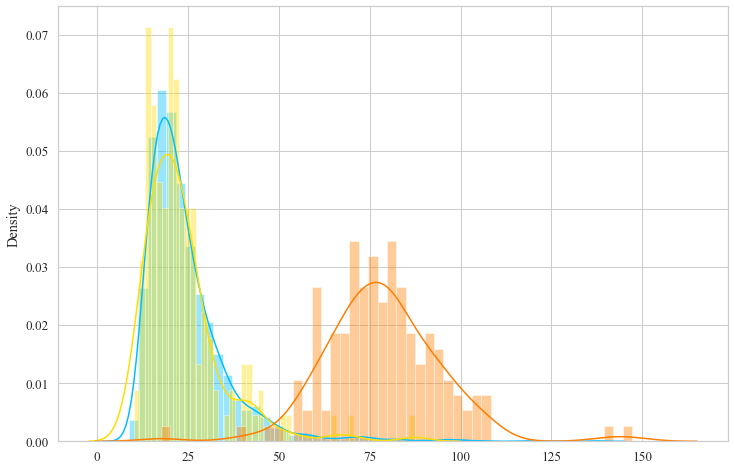

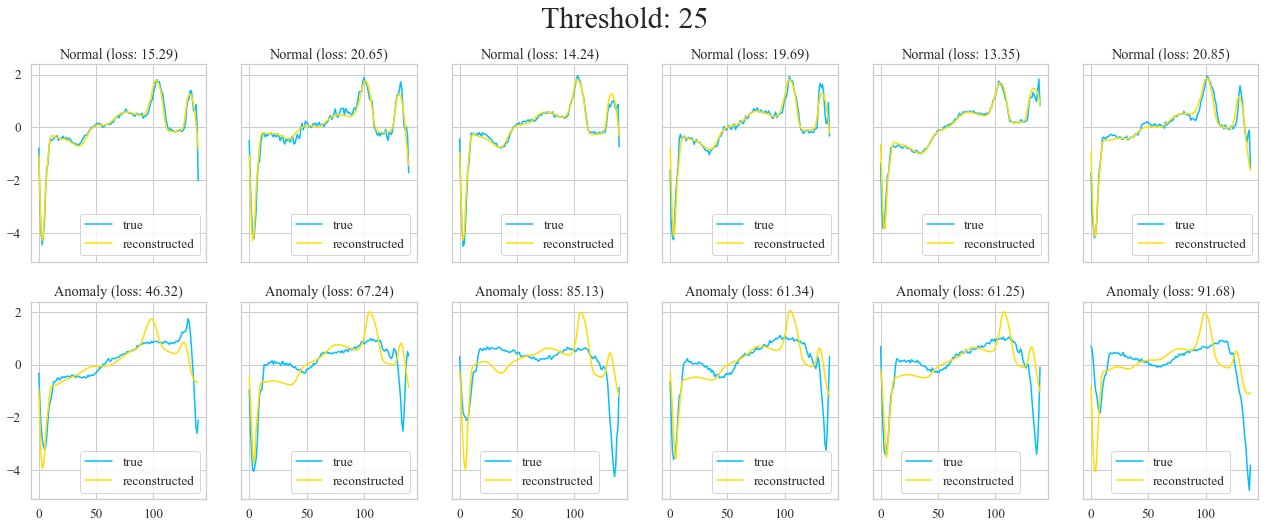

In [26]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 25


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold: 35

Correct normal predictions: 129/145 (88.97%)
Correct anomaly predictions: 144/145 (99.31%)


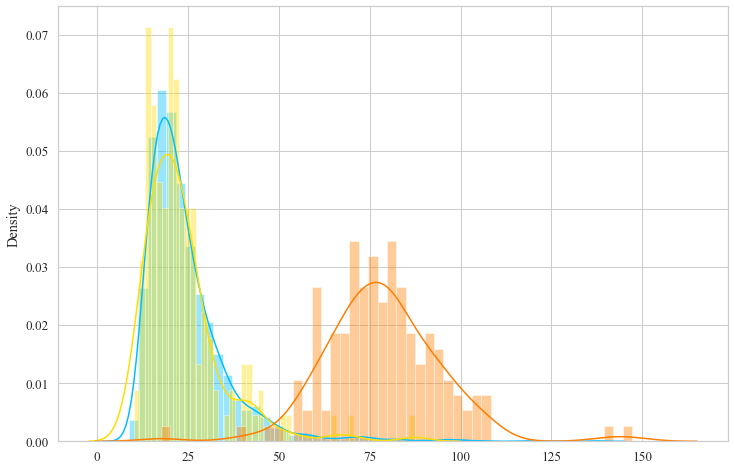

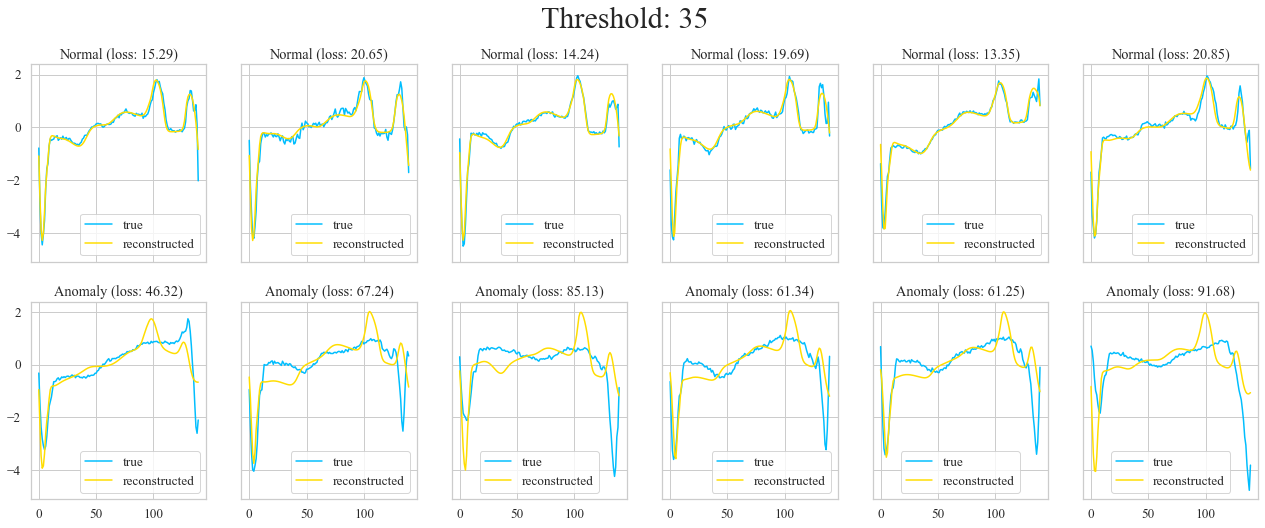

In [27]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 35


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold: 45

Correct normal predictions: 140/145 (96.55%)
Correct anomaly predictions: 143/145 (98.62%)


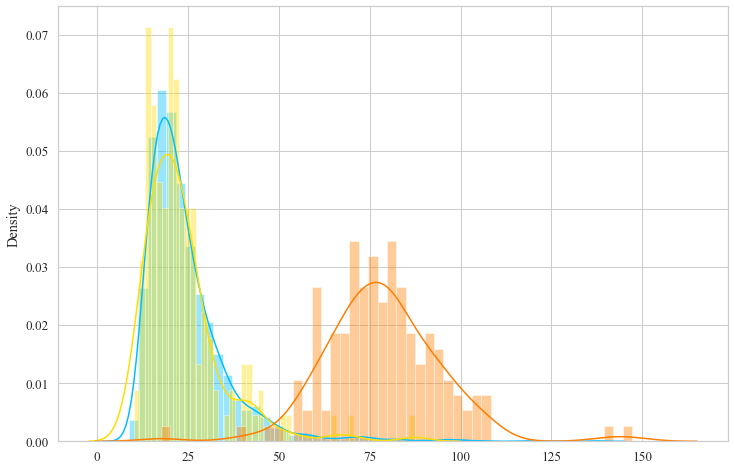

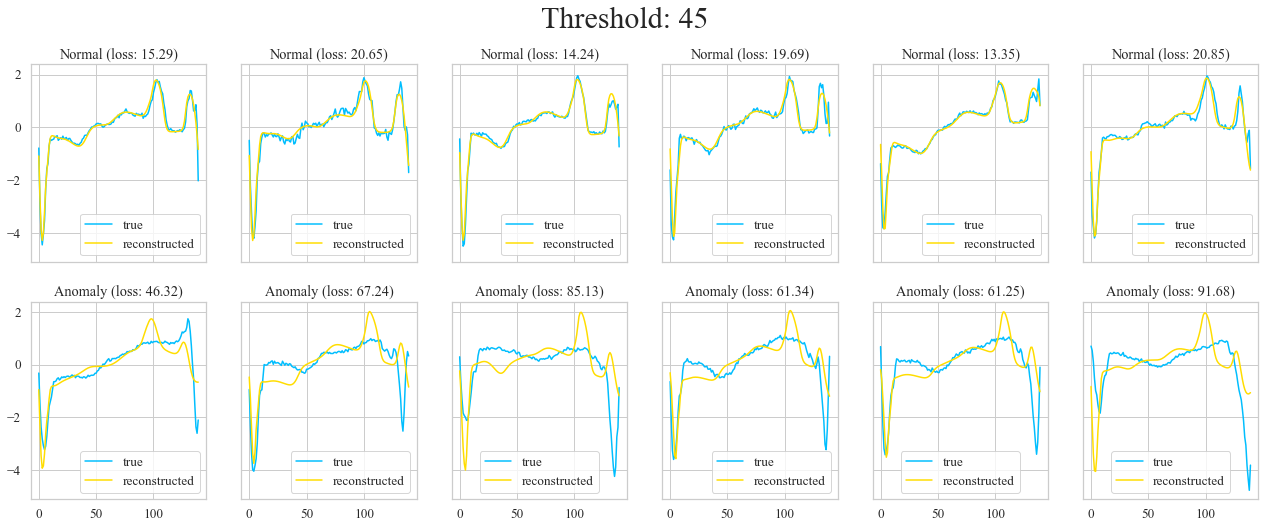

In [28]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 45


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold: 55

Correct normal predictions: 142/145 (97.93%)
Correct anomaly predictions: 140/145 (96.55%)


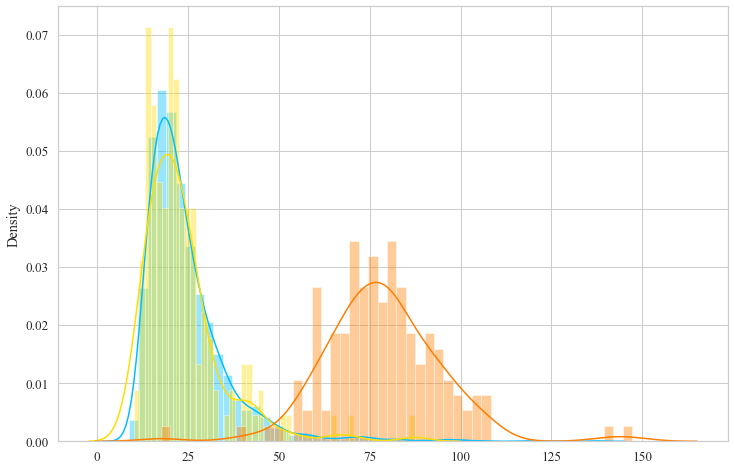

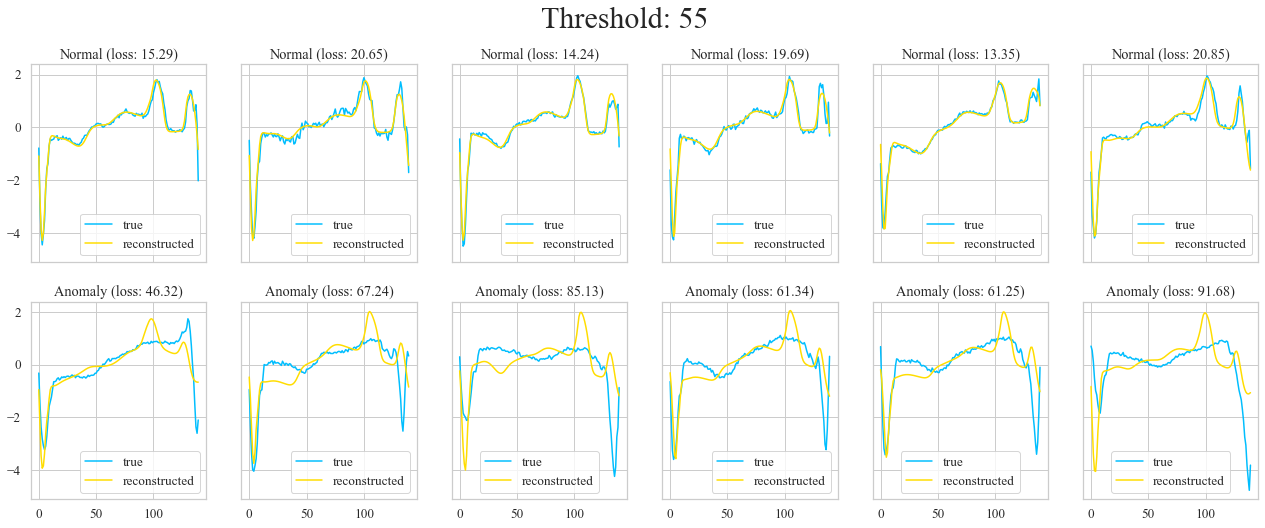

In [29]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 55


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold: 65

Correct normal predictions: 143/145 (98.62%)
Correct anomaly predictions: 122/145 (84.14%)


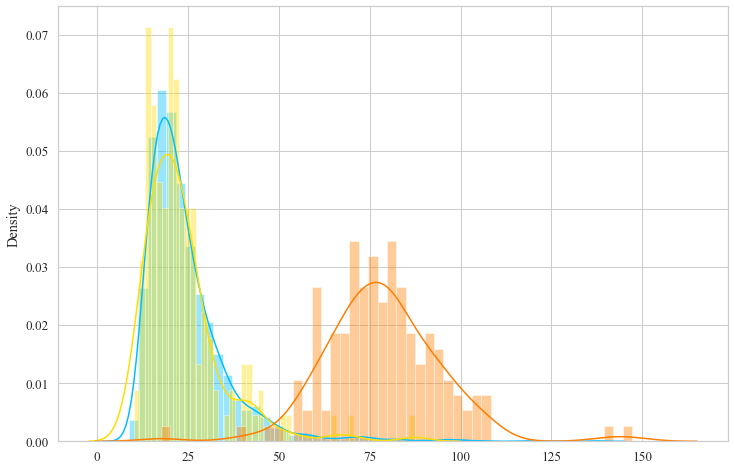

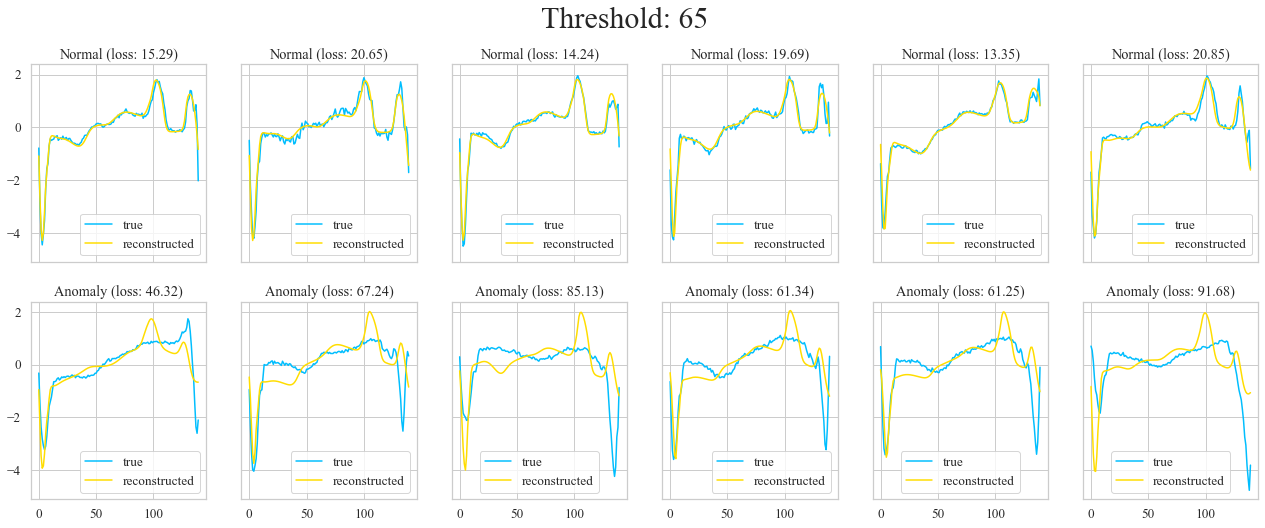

In [30]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 65


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold: 75

Correct normal predictions: 144/145 (99.31%)
Correct anomaly predictions: 85/145 (58.62%)


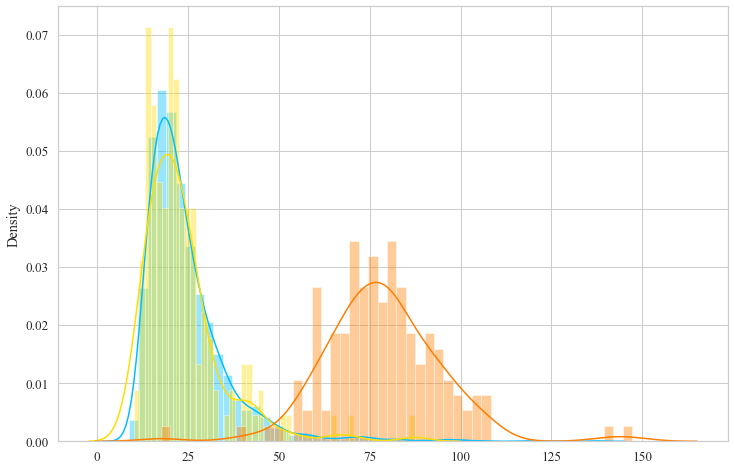

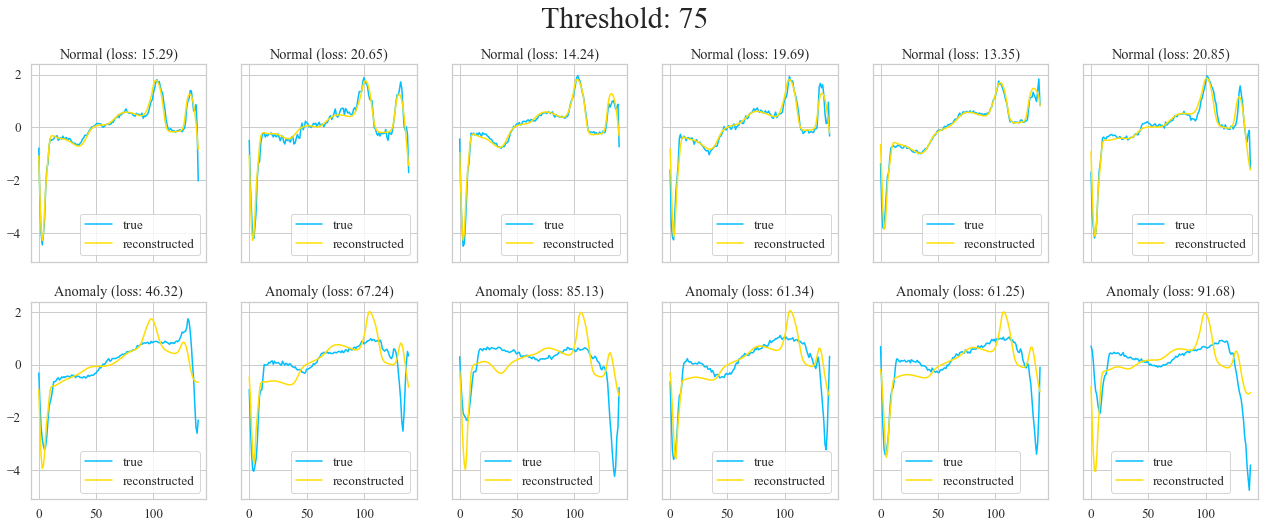

In [31]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 75


# Normal hearbeats

# Let's check how well our model does on normal heartbeats. 
# We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# We'll count the correct predictions:
correct = sum(l <= THRESHOLD for l in pred_losses)
normal_recall = correct/len(test_normal_dataset)
print('Correct normal predictions: ' + str(correct) + '/' + str(len(test_normal_dataset)) + ' (' + str(round(normal_recall*100, 2)) + '%)')


# Anomalies

# We'll do the same with the anomaly examples, but their number is much higher.
# We'll get a subset that has the same size as the normal heartbeats:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset
# Now we can take the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

# Finally, we can count the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
anomaly_recall = correct/len(anomaly_dataset)
print('Correct anomaly predictions: ' + str(correct) + '/' + str(len(anomaly_dataset)) + ' (' + str(round(anomaly_recall*100, 2)) + '%)')


# Looking at Examples

# We can overlay the real and reconstructed Time Series values to see how close they are.
# We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.suptitle('Threshold: ' + str(THRESHOLD), fontsize=30)
plt.show()

### Threshold Recall Bar Chart

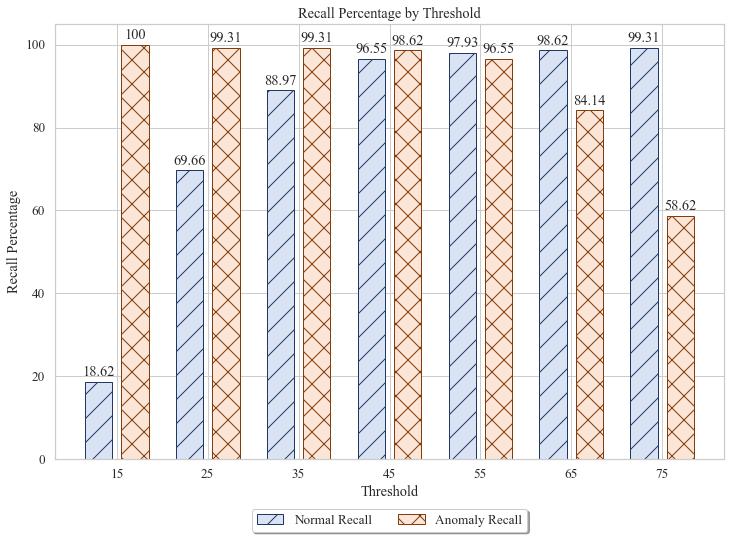

In [32]:
normal_recall_list = []
anomaly_recall_list = []
thresholds = np.arange(15, 85, 10)

for THRESHOLD in thresholds:
    # Normal hearbeats
    # Let's check how well our model does on normal heartbeats. 
    # We'll use the normal heartbeats from the test set (our model haven't seen those):
    predictions, pred_losses = predict(model, test_normal_dataset)
    # We'll count the correct predictions
    normal_correct = sum(l <= THRESHOLD for l in pred_losses)
    normal_recall = round(normal_correct/len(test_normal_dataset)*100, 2)
    normal_recall_list.append(normal_recall)

    # Anomalies
    # We'll do the same with the anomaly examples, but their number is much higher.
    # We'll get a subset that has the same size as the normal heartbeats:
    anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
    # anomaly_dataset = test_anomaly_dataset
    predictions, pred_losses = predict(model, anomaly_dataset)
    # Now we can take the predictions of our model for the subset of anomalies
    # Finally, we can count the number of examples above the threshold (considered as anomalies)
    correct = sum(l > THRESHOLD for l in pred_losses)
    anomaly_recall = round(correct/len(anomaly_dataset)*100, 2)
    anomaly_recall_list.append(anomaly_recall)

fig, ax = plt.subplots()
labels = [str(x) for x in thresholds]
x = np.arange(len(labels))

# print(thresholds, normal_recall_list, anomaly_recall_list)
normal_bar = ax.bar(x - 0.2, normal_recall_list, 0.3, label='Normal Recall', fc='#DAE3F3', edgecolor='#203864', 
                    hatch='/')
anomaly_bar = ax.bar(x + 0.2, anomaly_recall_list, 0.3, label='Anomaly Recall', fc='#FBE5D6', edgecolor='#843C0C', 
                     hatch='x')
ax.set_ylabel('Recall Percentage')
ax.set_xlabel('Threshold')
ax.set_title('Recall Percentage by Threshold')
ax.set_xticks(x, labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
ax.bar_label(normal_bar, padding=3)
ax.bar_label(anomaly_bar, padding=3)

plt.show()

<span style="color:red">
    <p>
    b) Briefly explain the trend you see in the <i>recall</i> values as you increase the threshold.
    </p>
</span>

When the embedding dimension is fixed, as the threshold is increased, normal recall increases. However, when the embedding dimension is fixed, as the threshold is increased, anomaly recall decreases. As the threshold is increased, more instances are classified as normal since the loss tolerance is greater relative to the previous threshold step.